In [1]:
from torch.optim import Adam
import torch
import torchvision
from torchvision.transforms import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import mlflow
import matplotlib.pyplot as plt
from einops import rearrange
import torch.nn.functional as F
import tempfile
from win10toast import ToastNotifier
import os
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
from torch import nn
import math
from typing import Tuple
import numpy as np
from scipy.stats import norm
import PIL
from torch import Tensor

c:\Users\Shlomi\AppData\Local\pypoetry\Cache\virtualenvs\text-conditioned-image-generation-using-st-35DVCAXA-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# TOC

**Table of contents**<a id='toc0_'></a>    
- [Datasets](#toc2_)    
- [Noise schedulers (linear, cosine)](#toc3_)    
  - [Linear](#toc3_1_)    
  - [Cosine](#toc3_2_)    
- [U-Net](#toc4_)    
- [Time embeddings (Sinusoidal)](#toc5_)    
- [Helper functions](#toc6_)    
  - [Transformations](#toc6_1_)    
  - [Plot histograms + KL-Divergence](#toc6_2_)    
- [Final Model (forward, backward diffusion)](#toc7_)    
- [Setup model + parameters](#toc8_)    
- [Train](#toc9_)    
- [Metrics (FID, IS)](#toc10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[TODO: List of things to do in this project](#toc0_)

* See the notebook code on the forward AND backward process in the model: https://github.com/dtransposed/code_videos/blob/main/01_Diffusion_Models_Tutorial/Diffusion%20Model.ipynb
* The model should remove noise (backward diffusion). I need to use "no grad" - i didn't use it
* Plot samples images (actually generate images from random noise) before are after each epoch training. Save it to mlflow


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

LR = 0.001

EPOCHS = 15
IMG_SIZE = 32
BATCH_SIZE = 64
T = 300
EXPERIMENT_NAME = "Training 2"

mlflow.end_run() # just in case

Using device: cuda


# <a id='toc2_'></a>[Datasets](#toc0_)

In [3]:
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Randomly flip horizontally so we have slightly different images every epoch
    transforms.Pad(2),
    transforms.ToTensor(),
])

train = torchvision.datasets.FashionMNIST(root="./data", download=True, transform=data_transform, train=True)

test = torchvision.datasets.FashionMNIST(root="./data", download=True, transform=data_transform, train=False)


train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [4]:
train_dataset = datasets.MNIST(root='../../data', train=True, download=True, transform=data_transform)
test_dataset  = datasets.MNIST(root='../../data', train=False, download=True, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

iter_test_dataloader = iter(test_dataloader) # For testing, plotting, validating

# <a id='toc3_'></a>[Noise schedulers (linear, cosine)](#toc0_)

## <a id='toc3_1_'></a>[Linear](#toc0_)

$\alpha_t$ controls how much noise we add at timestep $t$.

$\beta_t$ controls the variance of the noise added at timestep $t$.

1) $\alpha_t = 1 - \beta_t$ the noise strength changes at each timestep $t$ (depends on $\beta_t$)
2) $\bar{\alpha_t} = \prod_{s=1}^{t} a_s$

Equations (1) and (2) is from the paper "Denoising Diffusion Probabilistic Models"

3) $x_t = \sqrt{\bar{\alpha_t}} x_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon$ - the forward diffusion process $q(x_t | x_0)$

Equation (3): instead of iteratively adding noise, we do it in one single step (from $x_0$ we get to $x_t$). The $\epsilon$ is random Gaussian noise. I explain this equation in detail in the latex / PDF document (`single_step_forward_process.pdf`).

In [5]:
class LinearNoiseScheduler(nn.Module):
    def __init__(self, timesteps: int = 1000, beta_start: float = 1e-4, beta_end: float = 0.02):
        super().__init__()

        self.timesteps = timesteps

        # Start and end are the beta values for the linear noise schedule that we linearly interpolate between (hence linear scheduler)
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas # Equation 1
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)  # Equation 2
    
    def to(self, device):
        self.betas = self.betas.to(device)
        self.alphas = self.alphas.to(device)
        self.alpha_hat = self.alpha_hat.to(device)
        return self

    def forward(self, x0: Tensor, t: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Apply noise at level "t" to an image "x0".
        It applies the noise in a single step because of the Gaussian property of markov-chain of additive noise.

        x0: [B, C, H, W]
        t: [B, ]
        
        Returns:
            x_t: the noisy image at timestep t
            noise: the noise that was added
        """
        noise = torch.randn_like(x0)  # random Gaussian noise

        # Get the alpha_hat values for each t in the batch (shape: [B, 1, 1, 1] for broadcasting)
        alpha_hat_t = self.alpha_hat[t.long()].view(-1, 1, 1, 1)
        sqrt_alpha_hat_t = torch.sqrt(alpha_hat_t)
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - alpha_hat_t)

        x_t = sqrt_alpha_hat_t * x0 + sqrt_one_minus_alpha_hat_t * noise
        return x_t, noise

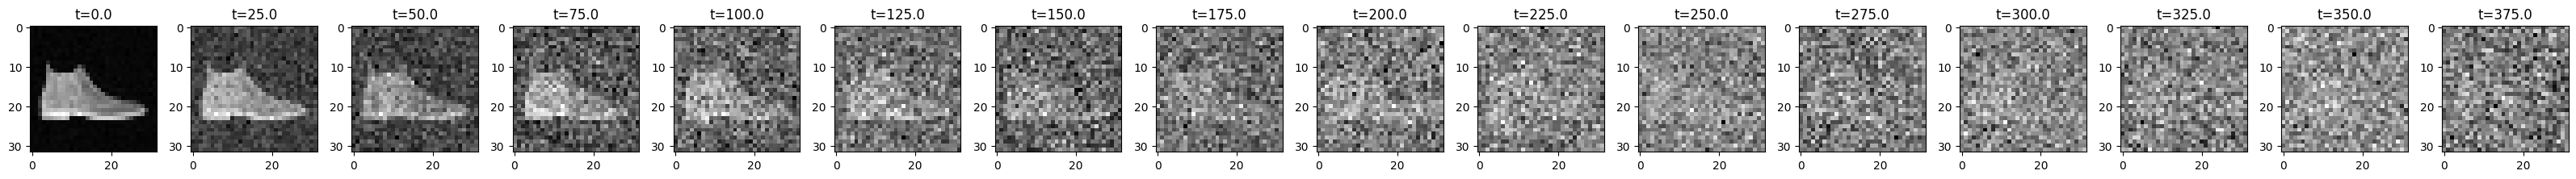

In [6]:
imgs, lbls = next(iter_test_dataloader)
linear_noise_sched = LinearNoiseScheduler()

num_of_imgs = 16

imgs = imgs[0].repeat(imgs.shape[0], 1, 1, 1) # Batch of the same first image
imgs = imgs[:num_of_imgs]

# different noise iterations
t = [25 * i for i in range(num_of_imgs)]
t = Tensor(t)

# apply noise
noisy_imgs, noise = linear_noise_sched.forward(imgs, t)

# Plot original + noisy images
fig, axes = plt.subplots(1, num_of_imgs, figsize=(32, 32))

# first row
for i in range(num_of_imgs):
    axes[i].imshow(rearrange(noisy_imgs[i], "b h w -> h w b"), cmap="gray")
    axes[i].set_title("t=" + str(t[i].item()))

plt.tight_layout()
plt.show()

## <a id='toc3_2_'></a>[Cosine](#toc0_)

In [7]:
class CosineNoiseScheduler(nn.Module):
    """
    s = 0.008 is set by the authors of the paper (section 3.2)
    """
    def __init__(self, timesteps = 1000, s=0.008):
        self.timesteps = timesteps
        self.s = s
        self.betas = self._cosine_beta_schedule()
        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)

    def _cosine_beta_schedule(self):
        steps = self.timesteps + 1
        t = torch.linspace(0, self.timesteps, steps) / self.timesteps
        alphas_bar = torch.cos(((t + self.s) / (1 + self.s)) * math.pi * 0.5) ** 2 # Formula 2
        alphas_bar = alphas_bar / alphas_bar[0] # formula 1
        betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
        return torch.clamp(betas, max=0.999)

    def forward(self, x0: Tensor, t: Tensor) -> Tuple[Tensor, Tensor]:
        """
        Adds "t" noise to "x0"

        x0: [B, C, H, W]
        t: [B, ]
        
        Returns:
            x_t: the noisy image at timestep t
            noise: the noise that was added
        """
        alpha_bar = self.alpha_cumprod[t.long()].view(-1, 1, 1, 1)
        noise = torch.randn_like(x0)
        return torch.sqrt(alpha_bar) * x0 + torch.sqrt(1 - alpha_bar) * noise, noise

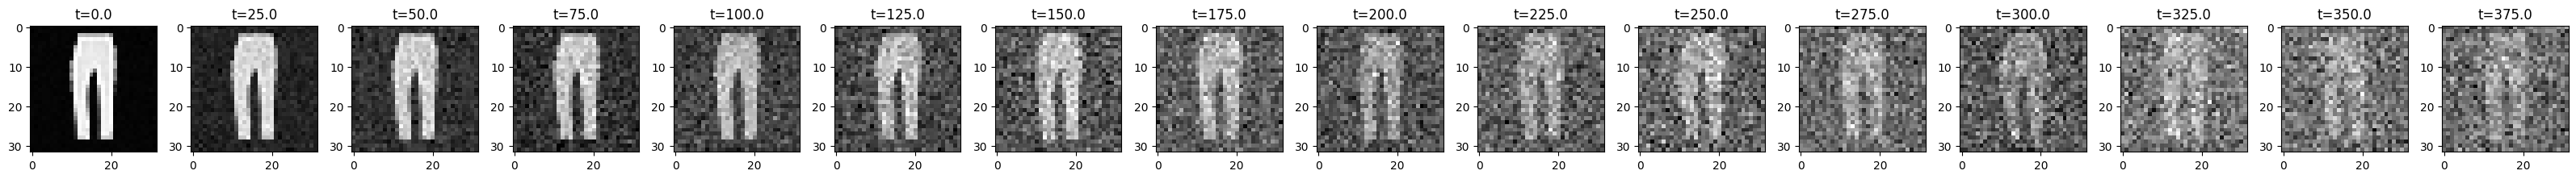

In [8]:
imgs, lbls = next(iter_test_dataloader)
cosine_noise_sched = CosineNoiseScheduler()

num_of_imgs = 16

imgs = imgs[0].repeat(imgs.shape[0], 1, 1, 1) # Batch of the same first image
imgs = imgs[:num_of_imgs]

# different noise iterations
t = [25 * i for i in range(num_of_imgs)]
t = Tensor(t)

# apply noise
noisy_imgs, noise = cosine_noise_sched.forward(imgs, t)

# Plot original + noisy images
fig, axes = plt.subplots(1, num_of_imgs, figsize=(32, 32))

# first row
for i in range(num_of_imgs):
    axes[i].imshow(rearrange(noisy_imgs[i], "b h w -> h w b"), cmap="gray")
    axes[i].set_title("t=" + str(t[i].item()))

plt.tight_layout()
plt.show()

# <a id='toc4_'></a>[U-Net](#toc0_)

In [9]:
"""
From the paper:
"It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) [i.e. DoubleConvolution module] and a 2x2 max pooling operation with stride 2 for downsampling [i.e. DownSampling module]."
"""
class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv_block(x)

class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConvolution(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        down = self.conv(x)
        pool = self.pool(down)

        return down, pool

"""
From the paper: 
"Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU"
"""
class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConvolution(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat((x1, x2), dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.dconv1 = DownSampling(in_channels, 64)
        self.dconv2 = DownSampling(64, 128)
        self.dconv3 = DownSampling(128, 256)
        self.dconv4 = DownSampling(256, 512)

        self.bottle_neck = DoubleConvolution(512, 1024)

        self.uconv1 = UpSampling(1024, 512)
        self.uconv2 = UpSampling(512, 256)
        self.uconv3 = UpSampling(256, 128)
        self.uconv4 = UpSampling(128, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1)
    
    def to(self, device):
        super().to(device)
        self.device = device
        return self

    def forward(self, x: Tensor) -> Tensor:
        d1,p1 = self.dconv1(x)
        d2,p2 = self.dconv2(p1)
        d3,p3 = self.dconv3(p2)
        d4,p4 = self.dconv4(p3)

        b = self.bottle_neck(p4)

        u1 = self.uconv1(b, d4)
        u2 = self.uconv2(u1, d3)
        u3 = self.uconv3(u2, d2)
        u4 = self.uconv4(u3, d1)

        out = self.out(u4)
        return out

# <a id='toc5_'></a>[Time embeddings (Sinusoidal)](#toc0_)

In [10]:
class SinusoidalEmbedding(torch.nn.Module):
    def __init__(self, embedding_dim: int):
        super().__init__()
        self.embedding_dim = embedding_dim
        assert self.embedding_dim % 2 == 0, "embedding_dim must be even"
    
    def to(self, device):
        super().to(device)
        self.device = device
        return self

    def forward(self, timesteps: Tensor) -> Tensor:
        # Create the frequency spectrum
        half_dim = self.embedding_dim // 2
        exponent = -math.log(10000.0) / (half_dim - 1)
        freq = torch.exp(torch.arange(half_dim, dtype=torch.float32) * exponent)
        # freq = freq.to(self.device)

        # Expand timesteps for broadcasting
        timesteps = timesteps.float().unsqueeze(1)  # (N, 1)
        args = timesteps * freq.unsqueeze(0)        # (N, half_dim)

        # Concatenate sin and cos
        embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=1)  # (N, embedding_dim)

        return embedding

Time embedding shape: torch.Size([100, 256])
Left half: sinus. Right half: cosine. See line: 
	
# Concatenate sin and cos
embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=1)  # (N, embedding_dim)



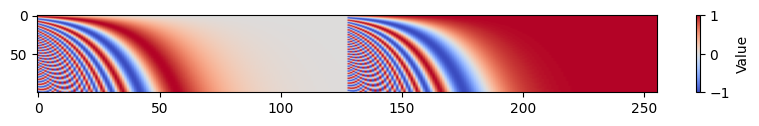

In [11]:
num_embeds = 100 # Number of vectors
embedding_dim = 256 # Vector size

semb = SinusoidalEmbedding(embedding_dim)

time_embeddings = torch.empty(num_embeds, embedding_dim)
for i in range(num_embeds):
    embd = semb.forward(Tensor([i]))
    time_embeddings[i] = embd

print("Time embedding shape: " + str(time_embeddings.shape))
txt = r"""
# Concatenate sin and cos
embedding = torch.cat([torch.sin(args), torch.cos(args)], dim=1)  # (N, embedding_dim)
"""
print("Left half: sinus. Right half: cosine. See line: \n\t" + txt)

plt.figure(figsize=(10, 1))
plt.imshow(time_embeddings, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Value')
# plt.axis('off')  # Optional: hide axes
plt.show()

# <a id='toc6_'></a>[Helper functions](#toc0_)

## <a id='toc6_1_'></a>[Transformations](#toc0_)

In [12]:
def to_plot(x: Tensor) -> PIL.Image.Image:
    """
    Parameters:
        x: A single image or multiple images [B, C, H, W]
    
    Returns:
        PIL.Image.Image to plot.
    """
    x = x.detach().cpu()
    if x.ndim == 4:
        x = rearrange(x, "b c h w -> b h w c")
    elif x.ndim == 3:
        x = rearrange(x, "c h w -> h w c")
    else:
        raise ValueError("Expected tensor of 3 or 4 dimensions")
    
    return x.numpy()

## <a id='toc6_2_'></a>[Plot histograms + KL-Divergence](#toc0_)

In [13]:
def kl_gaussians(mu1, std1, mu2, std2):
    """KL divergence between two Gaussians N(mu1, std1^2) || N(mu2, std2^2)"""
    var1, var2 = std1**2, std2**2
    return torch.log(std2 / std1) + (var1 + (mu1 - mu2)**2) / (2 * var2) - 0.5

Plot noise histograms with normal to determine our noise prediction with ground truth

In [14]:
def plot_noise_histogram_with_normal(
        first_tensor: Tensor, 
        second_tensor: Tensor, 
        title: str = "Noise Histograms Comparison",
        first_tensor_label: str = "Tensor 1 (blue)",
        second_tensor_label: str = "Tensor 2 (orange)",
        bins: int = 20,
        normalize: bool = False) -> Tensor:
    """
    Plots histograms and fitted normal distributions for two tensors.
    
    Parameters:
        first_tensor (Tensor): First tensor (e.g. noise image), shape (B, C, H, W)
        second_tensor (Tensor): Second tensor to compare with, same shape
        title (str): Title for the plot
        first_tensor_label (str): Legend label of first histogram
        second_tensor_label (str): Legend label of second histogram
        bins: Number of bins for the histogram
        normalize: If True, will normalize tensors to [0, 1] range
    
    Returns:
        kl_divergence (Tensor): The KL-Divergence between two distributions (first_tensor, second_tensor)
    """
    # Normalize
    if normalize:
        first_tensor = (first_tensor - first_tensor.min()) / (first_tensor.max() - first_tensor.min())
        second_tensor = (second_tensor - second_tensor.min()) / (second_tensor.max() - second_tensor.min())

    # Flatten and convert to numpy
    first_values = first_tensor.flatten().detach().cpu().numpy()
    second_values = second_tensor.flatten().detach().cpu().numpy()

    # Plot histograms
    plt.hist(first_values, bins=bins, density=True, alpha=0.5, label=first_tensor_label, color='skyblue')
    plt.hist(second_values, bins=bins, density=True, alpha=0.5, label=second_tensor_label, color='orange')

    # Normal distributions
    for values, color in zip(
        [first_values, second_values],
        ['blue', 'darkorange']
    ):
        mu, std = np.mean(values), np.std(values)

        x = np.linspace(values.min(), values.max(), 100)
        p = norm.pdf(x, mu, std)
        plt.plot(x, p, color=color, linewidth=2, label=f'PDF (μ={mu:.2f}, σ={std:.2f})')

    # Formatting
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

    mu1 = np.mean(first_values)
    std1 = np.std(first_values)
    mu2 = np.mean(second_values)
    std2 = np.std(second_values)
    kl_divergence = kl_gaussians(Tensor([mu1]), Tensor([std1]), Tensor([mu2]), Tensor([std2]))
    return kl_divergence

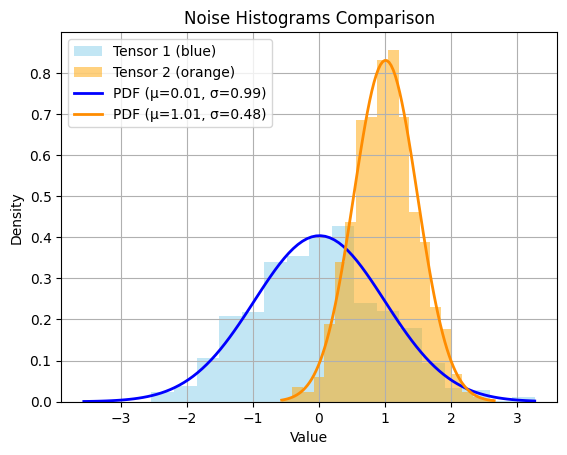

We have high KL-Divergence: tensor([3.0631])


In [15]:
noise1 = torch.randn(1, 1, 32, 32)
noise2 = torch.randn(1, 1, 32, 32) * 0.5 + 1.0  # different mean and std
kl_divergence = plot_noise_histogram_with_normal(noise1, noise2)
print("We have high KL-Divergence: " + str(kl_divergence))

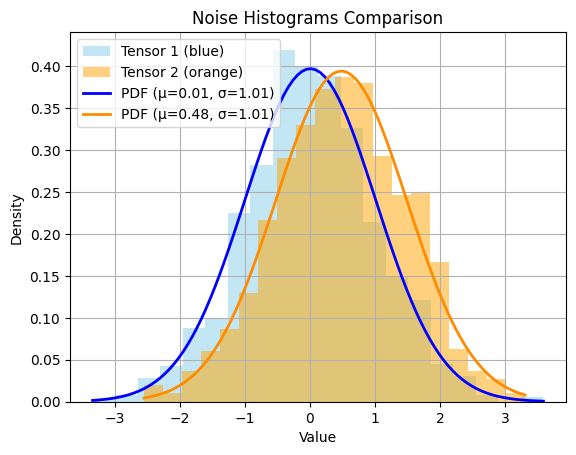

We have low KL-Divergence: tensor([0.1109])


In [16]:
noise1 = torch.randn(1, 1, 32, 32)
noise2 = torch.randn(1, 1, 32, 32) + 0.5  # different mean and std
kl_divergence = plot_noise_histogram_with_normal(noise1, noise2)
print("We have low KL-Divergence: " + str(kl_divergence))

# <a id='toc7_'></a>[Final Model (forward, backward diffusion)](#toc0_)

In [ ]:
class Model(nn.Module):
    def __init__(self, noise_scheduler: str = "linear", input_channels: int = 1, num_classes: int = 3):
        super().__init__()

        # Noise scheduler selection
        if noise_scheduler == "linear":
            self.noise_scheduler = LinearNoiseScheduler()
        elif noise_scheduler == "cosine":
            self.noise_scheduler = CosineNoiseScheduler()
        else:
            raise ValueError(f"Unknown noise scheduler: {noise_scheduler}")
        
        # U-Net selection
        self.unet = UNet(in_channels=input_channels, num_classes=num_classes)

        # Time embeddings
        self.time_embedding_dim = 256
        self.sinusoidalEmbedding = SinusoidalEmbedding(self.time_embedding_dim) # TODO: Do something with time embeddings


    def to(self, device):
        super().to(device)
        self.noise_scheduler.to(device)
        self.unet.to(device)
        self.sinusoidalEmbedding.to(device)
        return self

    def forward(self, x: Tensor, t: Tensor):
        """
        Forward diffusion (adding noise). Uses the selected noise scheduler.

        x: (B, C, H, W)
        t: (B, )
        """
        return self.noise_scheduler.forward(x, t)


    # Don't collect gradient information (no need to calculate loss here)
    # This is inference / sampling, not training
    @torch.no_grad()
    def backward(self, x, t):
        """
        Calls the model to predict the noise in the image and returns the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(torch.sqrt(1. - self.alphas_cumprod), t, x.shape)
        sqrt_recip_alphas_t = self.get_index_from_list(torch.sqrt(1.0 / self.alphas), t, x.shape)
        mean = sqrt_recip_alphas_t * (x - betas_t * self.forward(x, t) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = betas_t

        if t == 0:
            return mean
        else:
            noise = torch.randn_like(x)
            variance = torch.sqrt(posterior_variance_t) * noise 
            return mean + variance

# <a id='toc8_'></a>[Setup model + parameters](#toc0_)

In [18]:
model = Model(num_classes=1) # MNIST is 1 channel. We predict on 1 channels instead of 3.
model.to(device)

optimizer = Adam(model.parameters(), lr=LR)

## Forward diffusion

torch.Size([5, 1, 32, 32])
torch.Size([5])


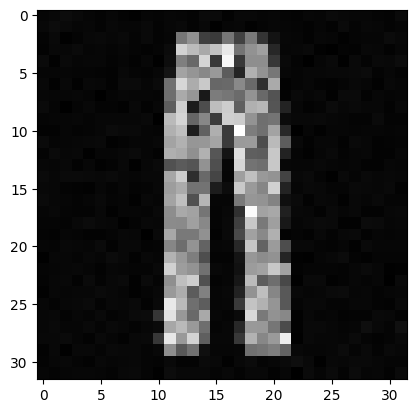

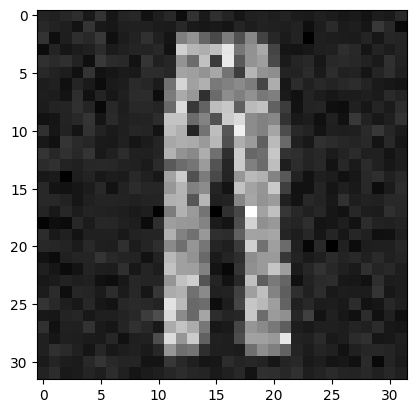

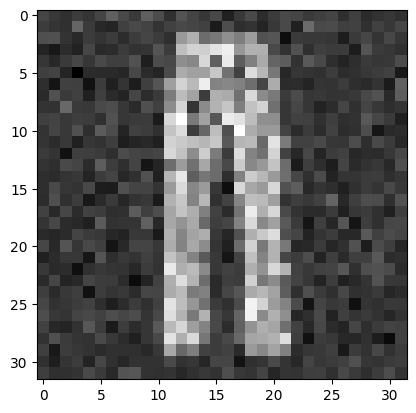

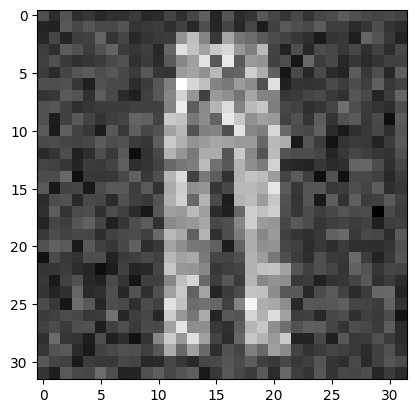

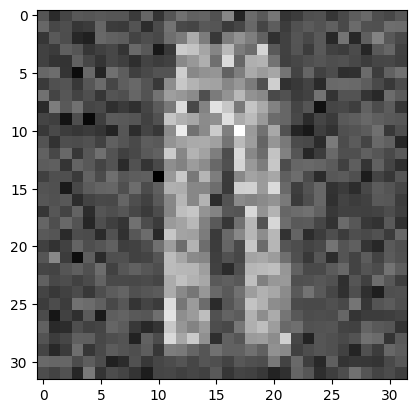

In [19]:
num_of_imgs = 5

imgs, lbls = next(iter_test_dataloader)
t = Tensor([i * 10 for i in range(num_of_imgs)])

imgs = torch.stack([imgs[0]] * num_of_imgs)

print(imgs.shape)
print(t.shape)

imgs = imgs.to(device)

noisy_imgs, noise = model.forward(imgs, t)

for img in noisy_imgs:
    plt.imshow(to_plot(img), cmap="gray")
    plt.show()

## Reverse diffusion

t = 215


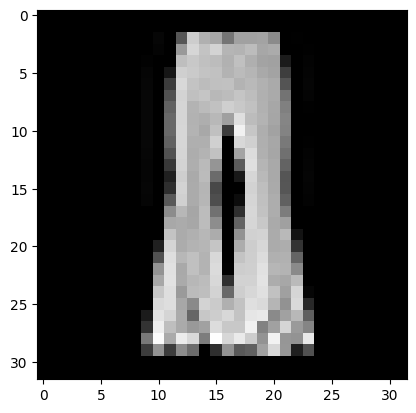

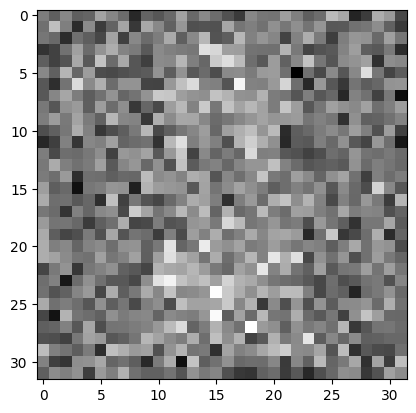

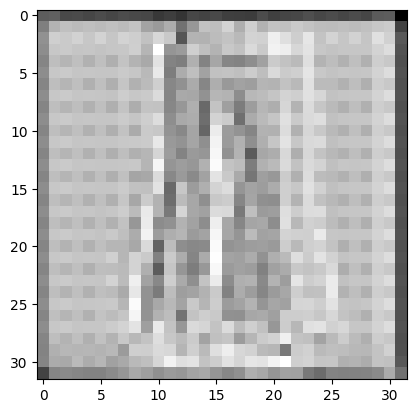

torch.Size([1, 32, 32]) torch.Size([1, 32, 32])


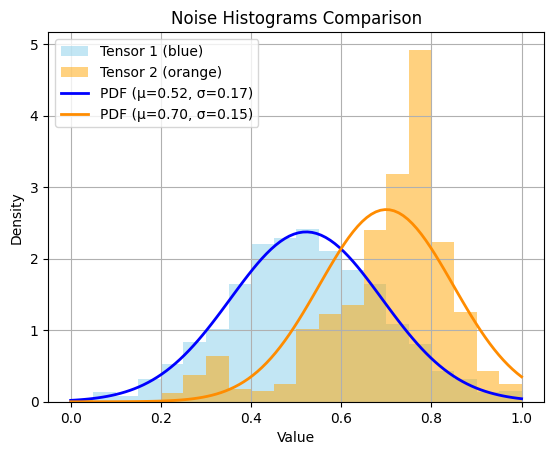

tensor([0.7319])

In [20]:
imgs, lbls = next(iter_test_dataloader)
imgs = imgs.to(device)

t = torch.randint(0, T, (BATCH_SIZE, ))

noisy_imgs, noise = model.forward(imgs, t)
noise_pred = model.backward(imgs, None)

print("t = " + str(t[0].item()))

plt.imshow(to_plot(imgs[0]), cmap="gray")
plt.show()

plt.imshow(to_plot(noisy_imgs[0]), cmap="gray")
plt.show()

plt.imshow(to_plot(noise_pred[0]), cmap="gray")
plt.show()

a = noise[0]
b = noise_pred[0]

print(a.shape, b.shape)
plot_noise_histogram_with_normal(a, b, normalize=True)

# <a id='toc9_'></a>[Train](#toc0_)

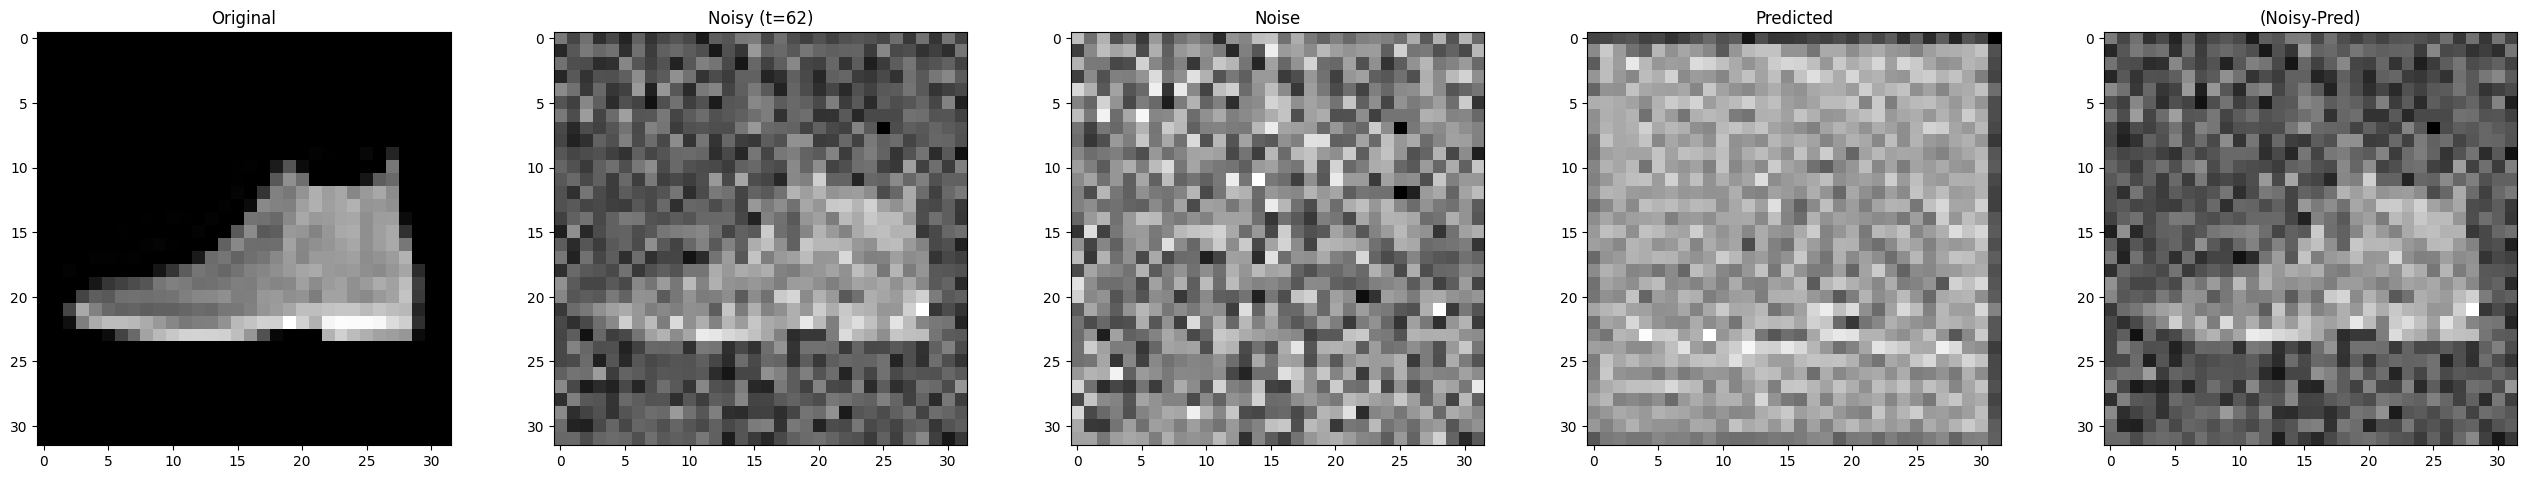

In [21]:
def log_plot_inference_and_fid_is_metrics(model, epoch, imgs, t, log_artifact: bool = True):
    """
    Plots the inference. Plots the original image, noisy image, first term, second term, predicted noise, and noisy image minus predicted noise.
    """
    x_noisy, noise = model.noise_scheduler(imgs, t)
    noise_pred = model.backward(x_noisy, t)

    # Plot original image, noisy image, noise, and predicted noise
    idx = 0
    original_image = imgs[idx].cpu()
    noisy_image = x_noisy[idx].cpu()
    noise_idx = noise[idx].cpu()
    # first_term_image = first_term[idx].cpu()
    # second_term_image = second_term[idx].cpu()
    predicted_noise_image = noise_pred[idx].cpu().detach()
    t_idx = t[idx].cpu().item()
    # minus = noisy_image - second_term_image
    noisy_minus_pred = noisy_image - predicted_noise_image

    num_of_subplots = 5
    subplot_index = 0

    fig, axes = plt.subplots(1, num_of_subplots, figsize=(32, 32))
    axes[subplot_index].imshow(rearrange(original_image, "c h w -> h w c"), cmap="gray")
    axes[subplot_index].set_title("Original")
    subplot_index += 1

    axes[subplot_index].imshow(rearrange(noisy_image, "c h w -> h w c"), cmap="gray")
    axes[subplot_index].set_title("Noisy (t="+str(t_idx)+")")
    subplot_index += 1

    axes[subplot_index].imshow(rearrange(noise_idx, "c h w -> h w c"), cmap="gray")
    axes[subplot_index].set_title("Noise")
    subplot_index += 1

    # axes[subplot_index].imshow(rearrange(first_term_image, "c h w -> h w c"), cmap="gray")
    # axes[subplot_index].set_title("First term")
    # subplot_index += 1

    # axes[subplot_index].imshow(rearrange(second_term_image, "c h w -> h w c"), cmap="gray")
    # axes[subplot_index].set_title("Second term")
    # subplot_index += 1

    axes[subplot_index].imshow(rearrange(predicted_noise_image, "c h w -> h w c"), cmap="gray")
    axes[subplot_index].set_title("Predicted")
    subplot_index += 1

    # axes[subplot_index].imshow(rearrange(minus, "c h w -> h w c"), cmap="gray")
    # axes[subplot_index].set_title("(Noisy-Second)")
    # subplot_index += 1

    axes[subplot_index].imshow(rearrange(noisy_minus_pred, "c h w -> h w c"), cmap="gray")
    axes[subplot_index].set_title("(Noisy-Pred)")
    subplot_index += 1


    plt.subplots_adjust(wspace=0.25)  # Increase gap between columns
    # plt.tight_layout()

    if log_artifact:
        img_name_prefix = EXPERIMENT_NAME + "_" + str(epoch) + "_"
        with tempfile.NamedTemporaryFile(prefix=img_name_prefix, suffix=".png", delete=False) as tmp:
            fig.savefig(tmp.name)
            mlflow.log_artifact(tmp.name, artifact_path="images")
        os.remove(tmp.name)
    else:
        plt.show()

    plt.close(fig)  # Clean up the figure

imgs, lbls = next(iter(test_dataloader))
imgs = imgs.to(device)
t = torch.randint(0, 100, (BATCH_SIZE,), device=device).long()
log_plot_inference_and_fid_is_metrics(model, 0, imgs, t, log_artifact=False)

# <a id='toc10_'></a>[Metrics (FID, IS)](#toc0_)

FID

In [22]:
def get_fid_score(original_images, generated_images):
    """
    FID evaluates diversity of generated images (generated_images) with in a reference dataset (original_images)
    """
    # Convert grayscale (1-channel) images to 3-channel
    if original_images.shape[1] == 1:
        original_images = original_images.repeat(1, 3, 1, 1)
        generated_images = generated_images.repeat(1, 3, 1, 1)

    fid = FrechetInceptionDistance(normalize=True).to(original_images.device)
    fid.update(original_images, real=True)
    fid.update(generated_images, real=False)
    return fid.compute()

imgs, lbls = next(iter(test_dataloader))
imgs = imgs.to(device)

fid = get_fid_score(imgs, imgs)
print("When the input is the exact same tensors, we expect FID score of 0, which is indeed the case")
print("Same images FID:", fid)

When the input is the exact same tensors, we expect FID score of 0, which is indeed the case
Same images FID: tensor(-0.0001, device='cuda:0')


IS

In [23]:
def get_is_metrics(original_images, generated_images):
    # Convert grayscale (1-channel) images to 3-channel
    if original_images.shape[1] == 1:
        original_images = original_images.repeat(1, 3, 1, 1)
        generated_images = generated_images.repeat(1, 3, 1, 1)
    
    is_metric = InceptionScore(normalize=True).to(device)
    is_score_original, is_std_original = is_metric(original_images)
    is_score_generated, is_std_generated = is_metric(generated_images)
    return is_score_original, is_std_original, is_score_generated, is_std_generated

imgs, lbls = next(iter(test_dataloader))
imgs = imgs.to(device)

is_score_original, is_std_original, is_score_generated, is_std_generated = get_is_metrics(imgs, imgs)
print("When the input is the exact same tensors, we expect exact same IS score, and indeed that is the case")
print(f"IS Score:\t\t{is_score_original}, IS STD:\t\t{is_std_original}")
print(f"IS Generated Score:\t{is_score_generated}, IS Generated STD:\t{is_std_generated}")

c:\Users\Shlomi\AppData\Local\pypoetry\Cache\virtualenvs\text-conditioned-image-generation-using-st-35DVCAXA-py3.11\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


When the input is the exact same tensors, we expect exact same IS score, and indeed that is the case
IS Score:		2.616600751876831, IS STD:		0.6537415981292725
IS Generated Score:	2.5914201736450195, IS Generated STD:	0.7043167948722839


In [24]:
def log_fid_is_metrics(model, epoch, imgs):
    # Add noise to the images
    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    x_noisy, noise = model.forward(imgs, t)

    # Get noise prediction
    noise_pred = model.backward(x_noisy, t)

    # Remove the predicted noise from noisy image
    samples = x_noisy - noise_pred

    fid = get_fid_score(imgs, samples)
    is_score_original, is_std_original, is_score_generated, is_std_generated = get_is_metrics(imgs, samples)

    mlflow.log_metrics({
        "fid": fid,
        "is_score_original": is_score_original,
        "is_score_original_std": is_std_original,
        "is_score_generated": is_score_generated,
        "is_score_generated_std": is_std_generated,
    }, step=epoch)

# Loss functions

In [ ]:
class LossFunction(nn.Module):
    def __init__(self, model, loss: str = "l1"):
        super().__init__()
        
        self.model = model
        self.loss = loss
    
    def forward(self, epoch: int, imgs: Tensor, t: Tensor) -> Tensor:
        if self.loss == "l1":
            x_noisy, noise = model.forward(imgs, t)
            noise_pred = model.backward(x_noisy, t)

            if last_epoch is None:
                last_epoch = epoch

            if epoch != last_epoch:
                plot_noise_histogram_with_normal(noise, 
                                                noise_pred, 
                                                title=f"Noise Histograms Comparison (epoch = {epoch})", 
                                                first_tensor_label="Ground truth noise", 
                                                second_tensor_label="Predicted noise")
                last_epoch = epoch

            loss = F.l1_loss(noise_pred, noise)
        elif self.loss == "mse":
            raise "Not yet implemented"
        else:
            raise ValueError(f"Loss function '{self.loss}' is not known.")
        return loss

In [ ]:
def log_checkpoint(model, epoch, log_every: int = 1):
    """
    Save model checkpoint each "log_every" epochs

    Parameters:
        log_every: If set to 1, will save checkpoint every 1 epoch. If set to 2, will save checkpoint every 2 epochs and so on.
    """
    if log_every == 1 or (epoch % log_every == 0):
        checkpoint_path = f"checkpoint_epoch_{epoch}.pt"
        torch.save(model.state_dict(), checkpoint_path)
        mlflow.log_artifact(checkpoint_path, artifact_path="checkpoints")
        os.remove(checkpoint_path)

# Sampling

![](notebook_imgs/sampling.png)

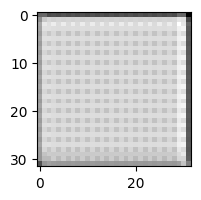

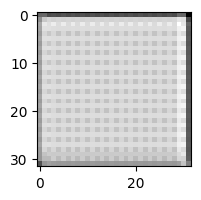

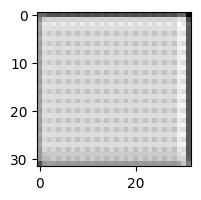

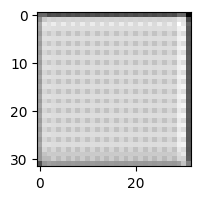

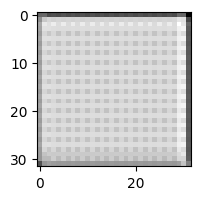

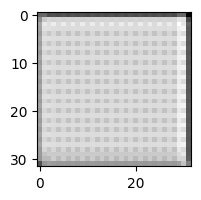

In [ ]:
def gen_and_plot_images():
    with torch.no_grad():
        # Line 1
        img = torch.randn((1, 1, IMG_SIZE, IMG_SIZE)).to(device) #x_T - the model will denoise this

        # Line 2
        for i in reversed(range(T)):
            t = torch.full((1,), i, dtype=torch.long, device=device) # Single tensor (i.e. the timestep in the for loop)


            img = model.backward(img, t) # We denoise the image at current timestep t

            if i % 50 == 0:
                plt.figure(figsize=(2, 2))
                plt.imshow(to_plot(img[0]), cmap="gray")
                plt.show()

gen_and_plot_images()

In [28]:
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

mlflow_run = mlflow.start_run()

mlflow.log_params({
    "lr": LR,
    "device": device,
    "optimizer": optimizer,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "image_size": IMG_SIZE,
    "T": T
})

mlflow.set_tag("Training Info", "Basic MNIST Fashion dataset")

# Training loop

![](notebook_imgs/training.png)

In [ ]:
batch_step = 0
last_loss_epoch = -1
running_loss = 0 # Epoch running loss

loss_function = LossFunction(model, "l1")

model.train()

for epoch in tqdm(range(EPOCHS)):
    # Logs an image of different plots. Each subplot is different image (original, noisy, the noise, predicted noise and so on)
    log_plot_inference_and_fid_is_metrics(model, epoch, imgs, t)

    # Save checkpoint each epoch
    log_checkpoint(model, epoch)

    # Log FID, IS metrics
    imgs, lbls = next(iter_test_dataloader)
    imgs = imgs.to(device)
    log_fid_is_metrics(model, epoch, imgs)

    # Line 1
    for step, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        # Line 2
        imgs, labels = batch
        imgs = imgs.to(device)

        # Line 3
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long() 
        
        # Lines 4, 5 (calculate loss, take gradient step until converged)
        loss = loss_function(epoch, imgs, t) # Calculate loss
        loss.backward() # Take gradient step
        optimizer.step() # Update model's parameters until converged

        running_loss += loss
        mlflow.log_metric("batch_loss", loss.item(), step=batch_step)
        batch_step += 1

    running_loss = (running_loss / batch_step).item()
    mlflow.log_metric("epoch_loss", running_loss, epoch)


  0%|          | 0/15 [00:05<?, ?it/s]


TypeError: LossFunction.forward() missing 1 required positional argument: 't'

# Generation test

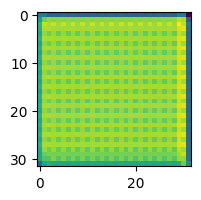

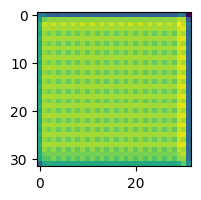

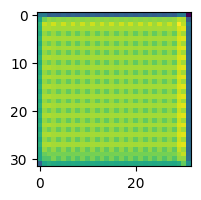

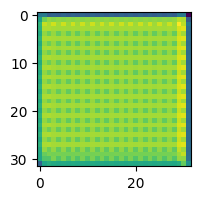

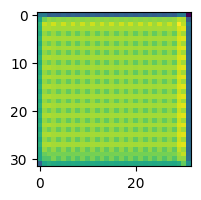

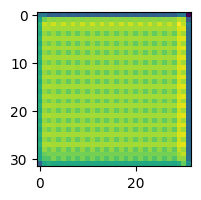

In [30]:
model.eval()

with torch.no_grad():
    img = torch.randn((1, 1, IMG_SIZE, IMG_SIZE)).to(device)
    for i in reversed(range(T)):
        t = torch.full((1,), i, dtype=torch.long, device=device)
        img = model.backward(img, t)
        if i % 50 == 0:
            plt.figure(figsize=(2,2))
            plt.imshow(to_plot(img[0]))
            plt.show()

Save model

In [ ]:
# torch.save(model.state_dict(), "model.pth")
mlflow.pytorch.log_model(model, artifact_path="models")

Generate images (the whole point of the model)

In [ ]:
with torch.no_grad():
    # Generate 16 random noise samples
    num_images = 16
    img_shape = (num_images, 1, IMG_SIZE, IMG_SIZE)
    img = torch.randn(img_shape).to(device)
    t = torch.zeros(num_images, dtype=torch.long).to(device)  # dummy timesteps

    # Predict noise and denoise
    noise_pred = model(img, t)
    img = img - noise_pred

    # Convert to grid for plotting
    grid = torchvision.utils.make_grid(img, nrow=4, normalize=True)  # normalize for display
    grid = grid.permute(1, 2, 0).cpu().numpy()  # CHW -> HWC

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.squeeze(), cmap="gray")  # squeeze if single channel
    plt.axis("off")
    plt.title("Generated Samples")
    plt.show()


Load model

In [ ]:
# # Load model
# model = Model()
# model.load_state_dict(torch.load("model.pth"))



In [ ]:
mlflow.end_run()

Notify windows that we finished running notebook

In [ ]:
if os.name == 'nt':
    notifier = ToastNotifier()
    notifier.show_toast("Notebook Run Complete", "Training finished.", duration=10, threaded=True)